## The Darcy's equation (piecewise-constant inputs)

## (1) Problem Description
We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function. 

We consider a problem with a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

### (2) Prepare data

The shape of a_train: torch.Size([10000, 841])
The shape of x_train: torch.Size([10000, 841, 2])
The shape of gridx_train: torch.Size([841, 2])
**********************************
The shape of a_test: torch.Size([200, 841])
The shape of x_test: torch.Size([200, 841, 2])
The shape of u_test: torch.Size([200, 841, 1])
The shape of gridx_test: torch.Size([841, 2])


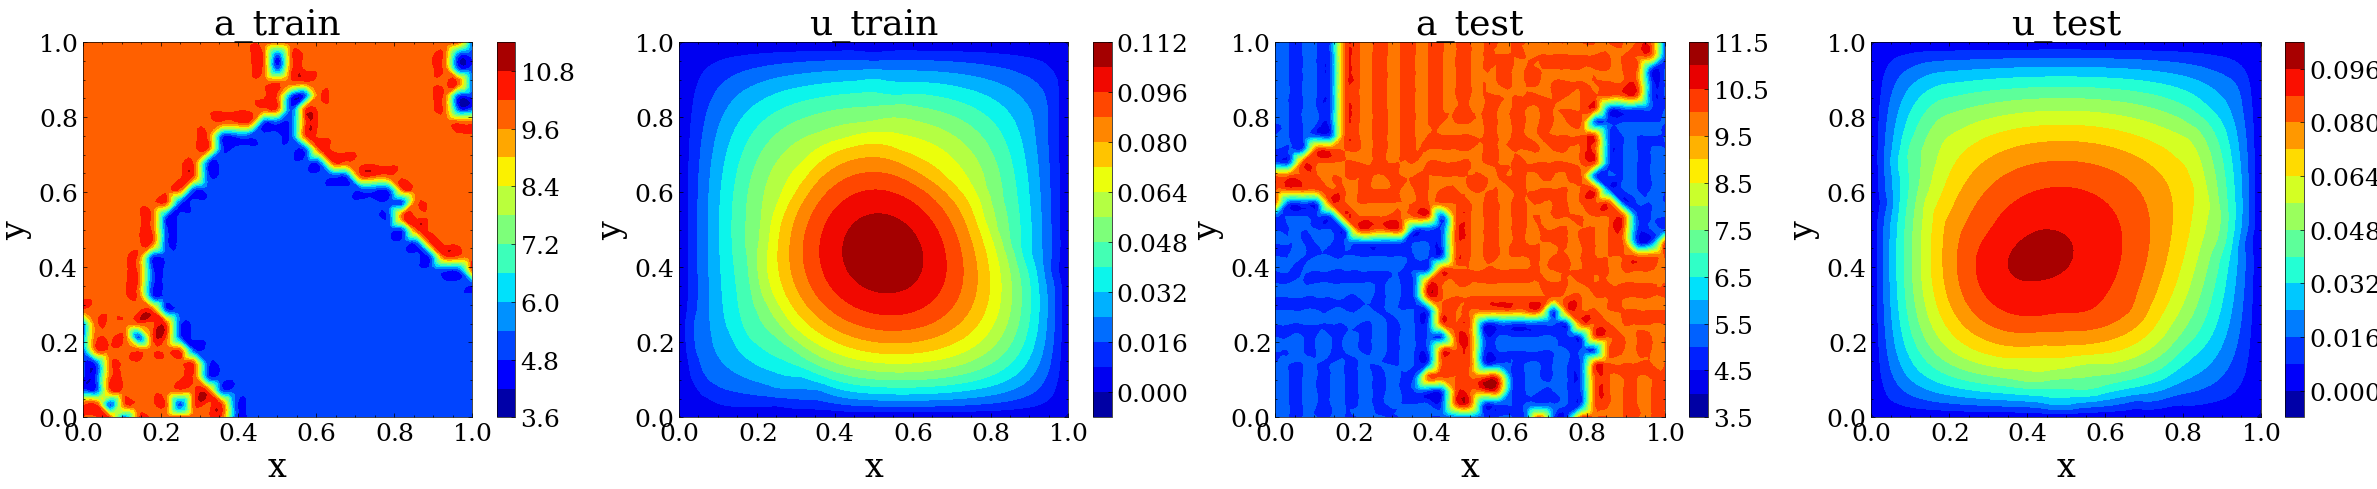

In [1]:
import sys 
sys.path.append("..") 
import numpy as np
import h5py
import torch 
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
random_seed = 10086
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
res_coe = 29
tag = 'data10000'

######################################
# Load training data
######################################
from Utils.utils import *
#
class Get_High_Resolution_a(object):

    def __init__(self, res=res_coe):
        super(Get_High_Resolution_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x_mesh, a_coe):
        ''' 
        Input:
            x_mesh: size(n_batch, n_mesh, 2)
            a_coe: size(n_batch, nx*ny)
        Result:
            a_new: size(n_batch, n_mesh)
        '''
        x_loc = torch.floor(x_mesh[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x_mesh[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        a_new = a_coe[torch.arange(a_coe.size(0)).unsqueeze(1), loc]
        
        return a_new
#
def get_data(data, dtype):
    a = np2tensor(np.array(data["coe"]), dtype)
    u = np2tensor(np.array(data["u"]), dtype)
    #
    X, Y = np.array(data['X']), np.array(data['Y'])
    mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
    gridx = mesh.reshape(-1, 2)
    #
    ndata = a.shape[0]
    a = a.reshape(ndata, -1)
    a_high_res = Get_High_Resolution_a()(gridx, a)
    x = gridx.repeat((ndata, 1, 1))
    u = u.reshape(ndata, -1, 1)
    
    return a_high_res, u, x, gridx
#
data_train = h5py.File('dataset/pwc_train_data10000.mat', 'r')
data_test = h5py.File('dataset/pwc_test_in.mat', 'r')
a_train, u_train, x_train, gridx_train = get_data(data_train, dtype)
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
print('The shape of a_train:', a_train.shape)
print('The shape of x_train:', x_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
print('**********************************')
print('The shape of a_test:', a_test.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of gridx_test:', gridx_test.shape)

########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([gridx_train]*4, [a_train[0], u_train[0], a_test[0], u_test[0]], 
                  ['a_train', 'u_train', 'a_test', 'u_test'], lb =0.)

### (3) Define the loss class

In [2]:
import torch.nn as nn
from torch.autograd import grad, Variable
from Utils.TestFun_ParticleWNN import TestFun_ParticleWNN
#
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)

###############################
# The test function
###############################
int_grid, v, dv_dr = TestFun_ParticleWNN(
    fun_type='Wendland', dim=2, n_mesh_or_grid=7, dataType=dtype).get_testFun()
print('int_grid shape:', int_grid.shape, 'v shape:', v.shape)

###############################
# Set normalizer
###############################
class UnitGaussianNormalizer():

    def __init__(self, a, eps=1e-8):
        super(UnitGaussianNormalizer, self).__init__()
        '''Apply normaliztion to inputs or outputs
        Input:
            a: size(N, mesh_size)
        Output:
            mean: size(mesh_szie,)
            std: size(mesh_size,)
        '''
        self.mean = torch.mean(a, 0)
        self.std = torch.std(a, 0)
        self.eps = eps
    
    def encode(self, a):
        '''
        Input:
            a: a: size(N, mesh_size)
        '''
        return (a - self.mean) / (self.std + self.eps)
    
    def decode(self, a):
        #
        return a * (self.std + self.eps) + self.mean
#
normalizer_a = UnitGaussianNormalizer(a_train.to(device))

###############################
# The mollifier 
###############################
class mollifier(object):

    def __inint__(self):
        super(mollifier, self).__init_()
        
    def __call__(self, u, x):
        '''
        u: size(n_batch, nx*ny) -> size(n_batch, nx*ny, 1)
        '''
        u = u * torch.sin(np.pi * x[...,0])*torch.sin(np.pi * x[...,1])
        return u.unsqueeze(-1)
        
##################################
##### The loss Class
##################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        #
        self.mollifier = mollifier()
        self.fun_a = Get_High_Resolution_a(res_coe)
        #
        self.model_enc = solver.model_dict['enc']
        self.model_u = solver.model_dict['u']
        self.model_a = solver.model_dict['a']
        self.model_s1 = solver.model_dict['s1']
        self.model_s2 = solver.model_dict['s2']
        #######################
        self.int_grid = int_grid.to(self.device)
        self.n_grid = int_grid.shape[0]
        self.v = v.to(self.device)
        self.dv_dr = dv_dr.to(self.device)

    def Loss_pde(self, a_batch, nc=100):
        '''The pde loss: weak residuals
        '''
        n_batch = a_batch.shape[0]
        beta = self.model_enc(normalizer_a.encode(a_batch))
        ############### Data points ###############
        # xc:size(nc, 1, 2) R:size(nc, 1, 1)
        xc, R = pointGen.weight_centers(n_center=nc, R_max=1e-4, R_min=1e-4)
        xc, R = xc.to(self.device), R.to(self.device)
        # size(nc, n_grid, 2)
        x = self.int_grid * R + xc
        # size(nc*n_grid, 2) -> (n_batch, nc*n_grid, 2)
        x = x.reshape(-1, 2).repeat((n_batch,1,1))
        x = Variable(x, requires_grad=True)
        ############### Test functions #############
        v = self.v.repeat((nc,1,1)).reshape(-1, 1)
        dv = (self.dv_dr / R).reshape(-1, 2)
        ################ model prediction ###########
        a_detach = self.fun_a(x.detach(), a_batch).unsqueeze(-1)
        # u: size(n_batch, nc*n_grid) -> size(n_batch, nc*n_grid, 1)
        u = self.model_u(x, beta)
        u = self.mollifier(u, x)
        # s: size(n_batch, nc*n_grid, 2)
        s = torch.stack([self.model_s1(x, beta), self.model_s2(x, beta)], dim=-1)
        # du: size(n_batch, nc*n_grid, 2)
        du = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        f = 10. * torch.ones_like(u)
        ################ PDE loss #################### 
        res1 = torch.sum( (s - a_detach * du)**2, dim=-1).reshape(n_batch, nc, self.n_grid)
        res1 = torch.mean(res1, dim=-1)
        # size(n_batch, nc*n_grid, 2) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        left = torch.sum(s * dv, dim=-1).reshape(n_batch, nc, self.n_grid)
        left = torch.mean(left, dim=-1)
        # size(n_batch, nc*n_grid, 1) -> (n_batch, nc, n_grid) -> (n_batch, nc)
        right = (f*v).reshape(n_batch, nc, self.n_grid)
        right = torch.mean(right, dim=-1)
        res2 = (left-right)**2

        return torch.mean(res1) + torch.mean(res2) * np.sqrt(nc) 
        
    def Loss_data(self, x, a, u):
        '''Note: u is not used for training
        '''
        beta = self.model_enc(normalizer_a.encode(a))
        a_pred = nn.Sigmoid()(self.model_a(x, beta))
        a_true = (a-5.)/5.
        return nn.functional.binary_cross_entropy(a_pred, a_true, reduction='mean')

    def Error(self, x, a, u):
        beta = self.model_enc(normalizer_a.encode(a))
        u_pred = self.model_u(x, beta)
        u_pred = self.mollifier(u_pred, x)

        return self.solver.getError(u_pred, u)
        
######################################
# Steups of the model
######################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
netType = 'MultiONetBatch' 
beta_size = 128      
hidden_size_a = 256
hidden_size = 100

####################################### The Encoder
from Networks.EncoderNet import EncoderFCNet
class Encoder(nn.Module):
    def __init__(self, layers_list, activation, dtype):
        super(Encoder, self).__init__()
        self.encoder = EncoderFCNet(layers_list, activation, dtype) 
        
    def forward(self, feat):
        '''
        Input:
            feat: size(batch_size, a_size)
        Return:
            output: size(?, beta_size) -> size(? beta_size)
        '''
        beta = self.encoder(feat)
        beta = torch.tanh(beta)
        return beta

model_enc = Encoder([a_train.shape[1], 512, 256, beta_size], 
                    'SiLU', dtype).to(device)

###################################### The Decoder
trunk_layers, branch_layers = [hidden_size_a]*5, [hidden_size_a]*5
model_a = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='SiLU_Sin', activation_branch='SiLU_Id',
                           netType=netType, sum_layers=4)
#
trunk_layers, branch_layers = [hidden_size]*5, [hidden_size]*5
model_u = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)
model_s1 = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)
model_s2 = solver.getModel(x_in_size=2, beta_in_size=beta_size, 
                          trunk_layers=trunk_layers, branch_layers=branch_layers,
                          activation_trunk='Tanh_Sin', activation_branch='Tanh_Sin',
                           netType=netType, sum_layers=4)

# ###############################
total_trainable_params_enc = sum(p.numel() for p in model_enc.parameters() if p.requires_grad)
print(f'{total_trainable_params_enc:,} training parameters.')
#
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')
#
print(f'{total_trainable_params_enc + total_trainable_params_u*4:,} total parameters')

int_grid shape: torch.Size([25, 2]) v shape: torch.Size([25, 1])
595,328 training parameters.
94,005 training parameters.
971,348 total parameters


### (4) train the model

In [ ]:
model_dict = {'u':model_u, 's1':model_s1, 's2':model_s2, 'a':model_a, 'enc':model_enc}
solver.train_setup(model_dict, lr=5e-4, optimizer='Adam', scheduler_type='StepLR', 
                   gamma=0.5, step_size=np.int32(1000/5))
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=1., w_pde=1., batch_size=25, epochs=1000, epoch_show=25,
             **{'save_path':f'saved_models/DGNO_latent{beta_size}_{tag}/'})

### (5) make prediction with trained model

The test l2 error (u avg): tensor(0.0241)


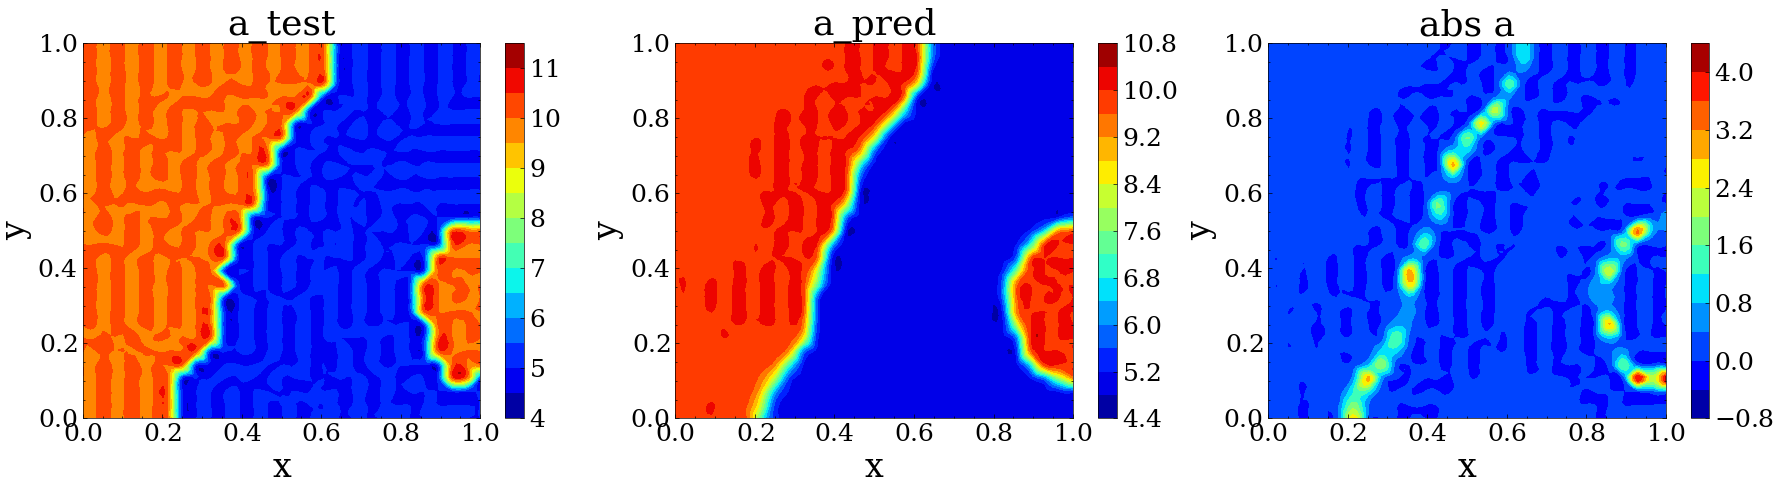

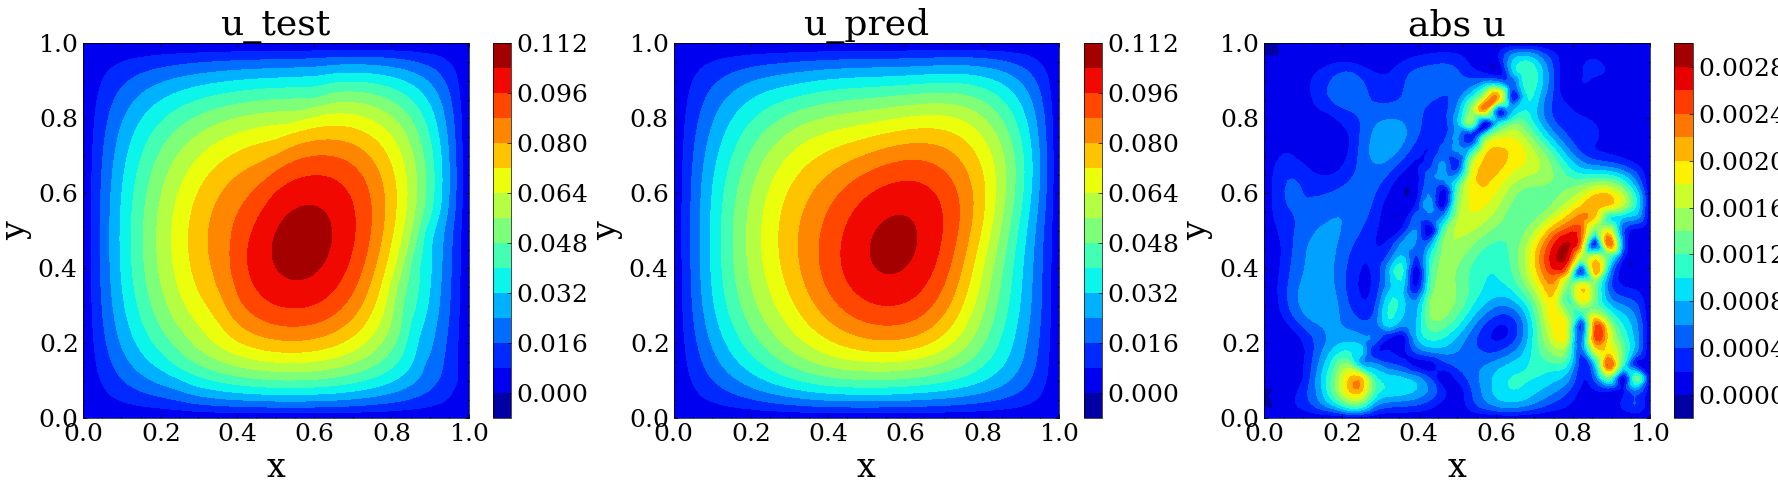

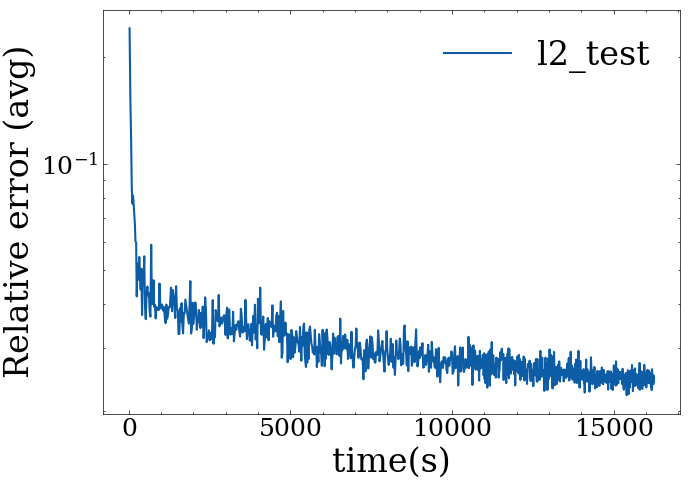

In [4]:
# #####################################
# # Load the trained model
# #####################################
from Solvers.DGNO import DGNO
solver = DGNO.Solver(device=device, dtype=dtype)
model_trained = solver.loadModel(path=f'saved_models/DGNO_latent{beta_size}_{tag}/', 
                                 name=f'model_dgno_final')
#
def a_sample(a_prob, samples=50):
    a = torch.zeros_like(a_prob)
    for i in range(samples):
        eps = torch.rand_like(a_prob)
        a += torch.log(eps) - torch.log(1-eps) + torch.log(a_prob+1e-8) - torch.log(1-a_prob+1e-8)
    a = nn.Sigmoid()(a/samples)*5. + 5.
    
    return a.detach().cpu()

#########################################
data_test = h5py.File('dataset/pwc_test_in.mat', 'r')
a_test, u_test, x_test, gridx_test = get_data(data_test, dtype)
#
with torch.no_grad():
    x_a = gridx_train.repeat(a_test.shape[0], 1, 1).to(device)
    x_u = x_test.to(device)
    #
    beta_pred = model_trained['enc'](normalizer_a.encode(a_test.to(device)))
    u_pred = model_trained['u'](x_u, beta_pred)
    u_pred = mollifier()(u_pred, x_u).detach().cpu()
    #
    a_pred = nn.Sigmoid()(model_trained['a'](x_a, beta_pred))
    a_pred = a_sample(a_pred)
#
print('The test l2 error (u avg):', solver.getError(u_pred, u_test))

# # ########################################
from Utils.PlotFigure import Plot
inx = 1
Plot.show_2d_list(gridx_train, [a_test[inx], a_pred[inx], torch.abs(a_test[inx]-a_pred[inx])], 
                  ['a_test', 'a_pred', 'abs a'], lb =0.)
Plot.show_2d_list(gridx_test, [u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  [ 'u_test', 'u_pred', 'abs u'], lb =0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/DGNO_latent{beta_size}_{tag}/', name='loss_dgno')
# Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
#                ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])